#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE, we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##Exercise 6.1: Variational Autoencoder and the reparameterization trick
The reparameterization trick is an important component of VAE. It allows to implement the sampling phase, while keeping the network trainable via gradient ascent/descent.
Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the sample layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. In particular, from this class we are interested in overriding the call method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the new Sampling layer has in input a mean vector $z_{\mu}$ and a ``variance'' vector $z_{\sigma}$, and it has to compute a sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{\mu} + exp(z_{\sigma}) \odot \epsilon,
$$
where $\epsilon$ is sampled by a normal distribution with zero mean and identity covariance matrix. 

**To complete: complete the code defining the Sampling layer that implements the reparameterization trick**

**Hint: to generate a random value from a normal distribution keras provides the [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.**

**In addition to that, explain why in the reparameterization formula it makes sense to use $exp(z_{\sigma})$ instead of directly using $z_{\sigma}$.**


In [0]:
class Sampling(tf.keras.layers.Layer):

    def call(self, inputs):
      z_Mean = inputs[0]
      z_Variance = inputs[1]
      epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_Mean),mean=0.0,stddev=1.0)
      z =  z_Mean + tf.multiply((tf.exp(0.5 * z_Variance[1])),epsilon)
      return z
 

#**Discussion**

The peculiarity that VAE is better than classic autoencoders is that it introduces to the network instead of directly mapping the input data points into latent variables the input data points get mapped to a multivariate normal distribution. This distribution limits the free rein of the encoder when it was encoding the input data points into latent variables. At the same time, it introduces stochasticity in the network because we are now sampling points from a probability distribution. 


1. Each data point in a VAE would get mapped to mean and log_variance vectors which would define the multivariate normal distribution around that input data point.


2.   A point is sampled from this distribution and is returned as the latent variable.


3. This latent variable is fed to the decoder to produce the output. 


The reason why in the reparametrization trick is that we take off the logaritm from the variance (log_variance) in order to have the real value of the variance. Besides we multiply that value for 0.5 to get the standard deviation. Since variance is usually a very small number computations involving that variable can be numerically unstable. Using logarithm it is possible to work in a larger range and so avoid big errors in floating point.


##Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW4), and then use the obtained encoding to compute $z_{\mu}$ and $z_\sigma$, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. 

In order to allow the exploration of the latent space, we will stick on a latent space of size $2$ (that is, the dimension of $z$ should be $2$).

**To complete: complete the code defining a deep encoder and the Dense layers that model $z_{\mu}$ and $z_\sigma$. Justify in this cell your choice for what concerns the layers sizes and the activation functions** 

In [214]:
latent_dim = 2
def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x= tf.keras.layers.Dense(512, activation='relu',name="Layer1")(encoder_inputs)
x= tf.keras.layers.Dense(384,activation=gelu, name="Layer2")(x)
x= tf.keras.layers.Dense(256,activation=gelu, name="Layer3")(x)
x= tf.keras.layers.Dense(128,activation='elu', name = "Layer4")(x)
x= tf.keras.layers.Dense(64,activation='elu', name = "Layer5")(x)



z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x) #To complete: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim, name="z_var")(x) #To complete: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 512)          401920      input_54[0][0]                   
__________________________________________________________________________________________________
Layer2 (Dense)                  (None, 384)          196992      Layer1[0][0]                     
__________________________________________________________________________________________________
Layer3 (Dense)                  (None, 256)          98560       Layer2[0][0]                     
____________________________________________________________________________________________

#**Discussion**

In the encoder part I chose this particular configuration because I made some experiment with different depth.

For the number of units I decided to decrease the units for each layer using the powers of 2 in order to try to be as balanced as possible between the various layers [784 -> 512 -> 384 -> 256 -> 128 -> 64].

For the activation functions I decided to put the **ReLu family** with its variations. The reason for my choice is that they are less expensive from a computational point of view than **tanh and sigmoid** because they involve simpler mathematical operations.  It also avoids the vanishing gradient problem. However **ReLu** introduces the dead relu problem, where components of the network are most likely never updated to a new value. This can sometimes be also be a pro. 

So I put **elu** in order to avoids this problem and produces negative outputs, which helps the network nudge weights and biases in the right directions. 

Finally I insert **gelu** beacuse because, despite how elu tries to avoid the problem of vanishing gradient, it has better performances than elu and ReLu, as reported in this article. So it can be considered a viable alternative to previous nonlinear approaches.

##Exercise 6.3: Decoder
Then we have to define the decoder part. It has in input $z$ and returns its "decoding". Its topology will have a ``mirror'' shape w.r.t. the encoder. 

**To complete: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes and the activation functions (in particular for what concerns the last layer)**

In [215]:
latent_inputs = keras.Input(shape=(latent_dim,))
x= tf.keras.layers.Dense(64,activation='elu', name = "Layer5")(latent_inputs)
x= tf.keras.layers.Dense(128,activation='elu',name="Layer4")(x)
x= tf.keras.layers.Dense(256,activation=gelu,name="Layer3")(x)
x= tf.keras.layers.Dense(384,activation=gelu,name="Layer2")(x)
x= tf.keras.layers.Dense(512,activation='relu',name="Layer1")(x)
decoder_outputs =tf.keras.layers.Dense(784,activation='sigmoid',name="Final_layer")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
Layer5 (Dense)               (None, 64)                192       
_________________________________________________________________
Layer4 (Dense)               (None, 128)               8320      
_________________________________________________________________
Layer3 (Dense)               (None, 256)               33024     
_________________________________________________________________
Layer2 (Dense)               (None, 384)               98688     
_________________________________________________________________
Layer1 (Dense)               (None, 512)               197120    
_________________________________________________________________
Final_layer (Dense)          (None, 784)               4021

#**Discussion**

Regarding the layers, the number of units and the activations functions I did the same with the encoder. About the last layer I chose the **sigmoid** activation function, because I noticed that trying to put the other functions like Relu, softmax, tanh the loss made me much worse. 


Another points to support **sigmoid** than ReLU is that considering the reconstruction loss is computed via binary crossentropy, sigmoid allows you to constrain the average of the output values in the range (0.1).

##Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad hoc training phase. In particular, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the original inputs, and a regularization loss that helps to learn well-formed latent spaces (Gaussian prior) and reduces overfitting to the training data. The regularization loss involves the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**To complete: implement the reconstruction loss and KL-loss (look at the VAE paper in Moodle)**

In [0]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)


            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data,reconstruction))
            reconstruction_loss *= 784
            
            z_mean_squared =tf.keras.backend.square(z_mean)
            kl_loss = -0.5 *  tf.reduce_mean(1+ z_var- z_mean_squared -tf.exp(z_var))


            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer

In [217]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vae.fit(x_train, epochs=100, batch_size=256)

Epoch 1/100
196/196 [==============================] - 1s 7ms/step - loss: 194.6627 - reconstruction_loss: 191.3150 - kl_loss: 3.3477
Epoch 2/100
196/196 [==============================] - 1s 6ms/step - loss: 163.0018 - reconstruction_loss: 159.7453 - kl_loss: 3.2566
Epoch 3/100
196/196 [==============================] - 1s 6ms/step - loss: 154.9021 - reconstruction_loss: 151.5239 - kl_loss: 3.3782
Epoch 4/100
196/196 [==============================] - 1s 6ms/step - loss: 150.0048 - reconstruction_loss: 146.4580 - kl_loss: 3.5468
Epoch 5/100
196/196 [==============================] - 1s 6ms/step - loss: 147.0174 - reconstruction_loss: 143.4176 - kl_loss: 3.5998
Epoch 6/100
196/196 [==============================] - 1s 6ms/step - loss: 144.9514 - reconstruction_loss: 141.2900 - kl_loss: 3.6614
Epoch 7/100
196/196 [==============================] - 1s 6ms/step - loss: 143.1674 - reconstruction_loss: 139.4566 - kl_loss: 3.7108
Epoch 8/100
196/196 [==============================] - 1s 5ms/

##Exercise 6.5: Model Analysis
We can now plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate several  2D $\hat{z}$ samples and pass them to our decoder. The interval where to sample  $\hat{z}$ can be controlled by the $scale$ parameter, while the number of generated samples is controlled by the $n$ parameter.


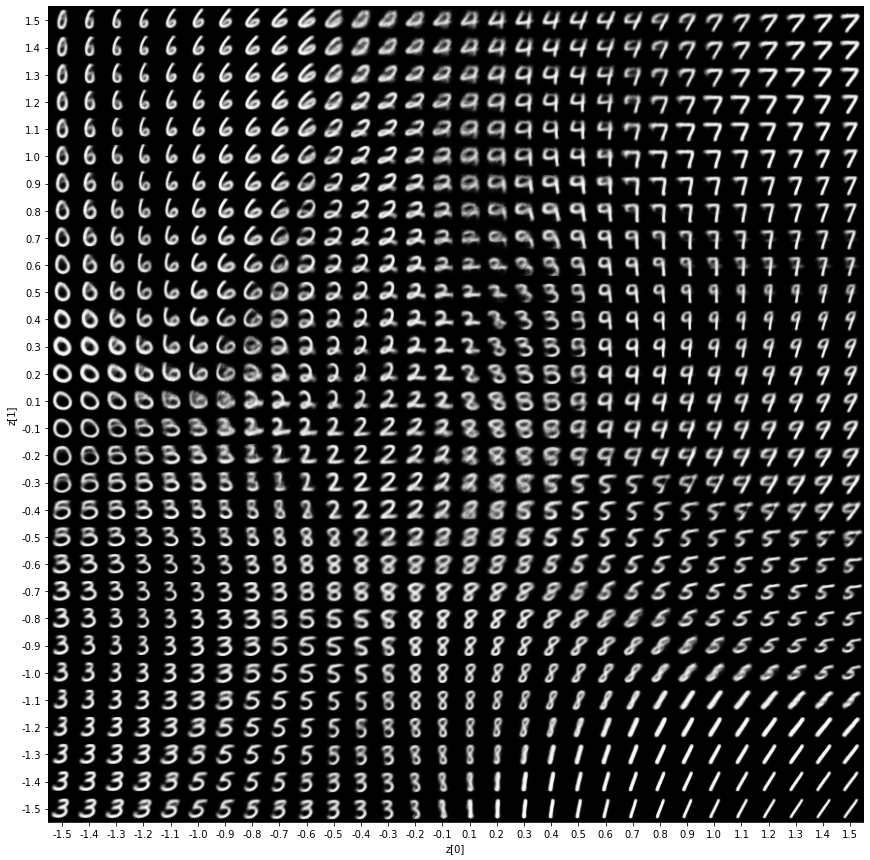

In [218]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 1.5, 30) 

#To complete: explore with different "scale"

Let's finaly check how the different digits have been rapresented in the latent space by the VAE.

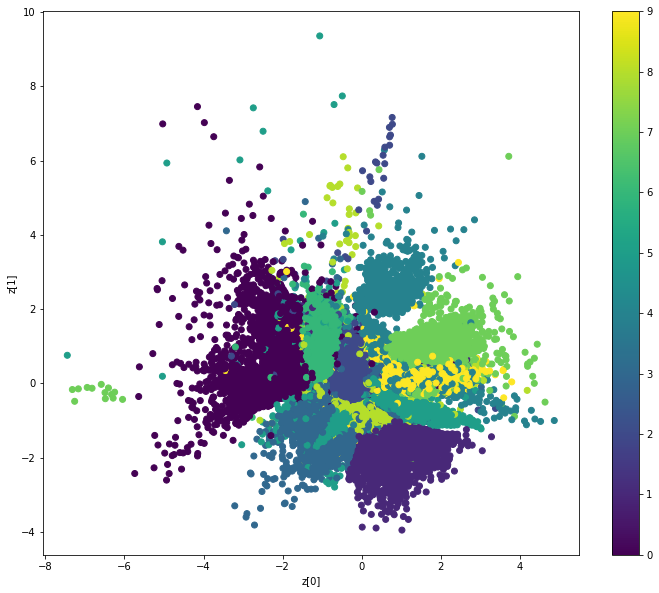

In [219]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**To complete: Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result.**

#**Discussion**

Here you have 2 types of graphs, one latent **(latent plot)** while the second is a **label cluster plot**.

Both graphs express the same thing but highlight different things. The first one, the **latent plot**, shows how the values that have been generated are distributed within the latent space. As you can see rationally all the images represented are "significant", i.e. they represent a number. 

As for the second plot, it shows the label distributions in the latent space. It means that how the two parameters z[1] and z[2] of the latent space contribute to the definition of a particular number   

1. **Latent plot and label cluster plot of my best model [784 -> 512 -> 384 -> 256 -> 128 -> 64]**


<img src="https://user-images.githubusercontent.com/53294518/83892779-6eb78f80-a74f-11ea-85cd-62e33f045336.png" width="500"/>


<img src="https://user-images.githubusercontent.com/53294518/83892840-7d9e4200-a74f-11ea-88bb-14d2f33c7af6.png" width="500"/>


Depending on the region in latent space, such as **z[1] = -0.2 and z[0] = 0.2**, we notice the number a bit blurred. This is also present in the label graph where in correspondence "about" of that point identified by **z[1] and z[0]** we notice a mixture of colors and little differentiation. Aside from small nuances on the whole the represented image seems quite good.


Obviously, by changing the VAE hyper-parameters you get different representations, in particular by changing the number of layers and the number of parameters of each layer. 

I increased the number of epochs to 100 because I noticed I had the best epoch at that value. If I already put 150 I didn't see any improvement, while 50 I saw that I stopped the training when it was improving.


2. **Latent plot and label cluster plot with an extra layers:**


So 6 Dense Layer and regarding of number of units: [784 -> 512 -> 384 -> 256 -> 128 -> 64 -> 32]

<img src="https://user-images.githubusercontent.com/53294518/83889400-64939200-a74b-11ea-845c-434d7825e183.png" width="500"/>

<img src="https://user-images.githubusercontent.com/53294518/83889438-6fe6bd80-a74b-11ea-8e7b-2f027e5516b7.png" width="500"/>



We can see that labels are more overlapped and digits sampled from the latent space are generally malformed: some of them are just blurred, others are confused and there are also "tilted" ones. In general, the quality of the representation is quite bad, expecially if compared to the reference mode

3. **Latent Plot and label cluster plot with only two Dense layers** 

So 2 Dense Layer and regarding of number of units: [784 -> 256 -> 64]

<img src="https://user-images.githubusercontent.com/53294518/83891725-e97fab00-a74d-11ea-8ee5-be46fdb9bf80.png" width="500"/>
<img src="https://user-images.githubusercontent.com/53294518/83891754-f1d7e600-a74d-11ea-93be-cfef083f0bb4.png" width="500"/>

The representation of the numbers in the latent space as well as that of the labels is more confusing than that of our best solution. The pattern represents too few layers as well as units. You have to find the right balance between layers and units. 